# TD法による方策評価

In [1]:
class TdAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.01
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)

    def get_action(self, state):
        ps = self.pi[state]
        actions, probs = list(ps.keys()), list(ps.values())
        return np.random.choice(actions, p=probs)

    def eval(self, state, reward, next_state, done):
        # doneの時は0、それ以外はnext_V = V[next_state]
        next_V = 0 if done else self.V[next_state]
        target = self.gamma * next_V + reward

        # 更新
        self.V[state] += (target - self.V[state]) * self.alpha 

In [2]:
from common.gridworld import GridWorld
from collections import defaultdict
import numpy as np
env = GridWorld()
agent = TdAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.eval(state, reward, next_state, done)
        if done:
            break
        state = next_state

env.render_v(agent.V)

<Figure size 640x480 with 1 Axes>

# SARSA

In [3]:
from collections import defaultdict, deque
import numpy as np
from common.utils import greedy_action_probs

class SarsaAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(float)
        self.experience = deque(maxlen=2)  # dequeを使う

    def get_action(self, state):
        ps = self.pi[state]  # piから選ぶ
        actions, probs = list(ps.keys()), list(ps.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.experience.clear()

    def update(self, state, action, reward, done):
        # 2つを超えた場合は、先に入ったものが削除される
        self.experience.append((state, action, reward, done))
        if len(self.experience) < 2:
            return
        state, action, reward, done = self.experience[0]
        next_state, next_action, _, _ = self.experience[1]
        next_q = 0 if done else self.Q[next_state, next_action]  # 次のQ関数

        # TD法による更新
        target = self.gamma * next_q + reward
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        # 方策の改善
        self.pi[state] = greedy_action_probs(self.Q, state, self.epsilon)

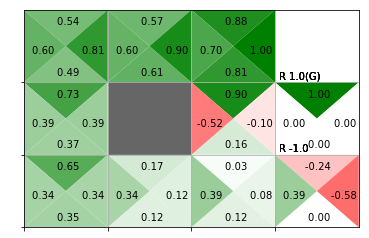

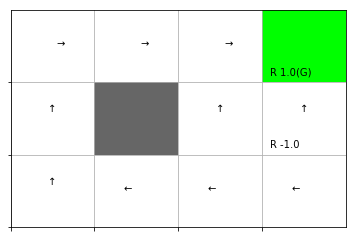

In [4]:
env = GridWorld()
agent = SarsaAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)  # 毎回呼ぶ

        if done:
            agent.update(next_state, None, None, None)  # ゴールに到達したときにも呼ぶ
            break
        state = next_state

env.render_q(agent.Q)

# 方策オフ型のSARSA

In [5]:
class SarsaOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions) # ターゲット方策
        self.b = defaultdict(lambda: random_actions) # 挙動方策
        self.Q = defaultdict(float)
        self.experience = deque(maxlen=2)

    def get_action(self, state):
        ps = self.b[state]  # 挙動方策から取得
        actions, probs = list(ps.keys()), list(ps.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.experience.clear()

    def update(self, state, action, reward, done):
        self.experience.append((state, action, reward, done))
        if len(self.experience) < 2:
            return
        state, action, reward, done = self.experience[0]
        next_state, next_action, _, _ = self.experience[1]

        if done:
            next_q = 0
            rho = 1
        else:
            next_q = self.Q[next_state, next_action]
            # 重みrhoを求める
            rho = self.pi[next_state][next_action] / self.b[next_state][next_action]

        # rhoによるTDターゲットの補正
        target = rho * (self.gamma * next_q + reward)
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        # それぞれの方策を改善
        self.pi[state] = greedy_action_probs(self.Q, state, 0)
        self.b[state] = greedy_action_probs(self.Q, state, self.epsilon)

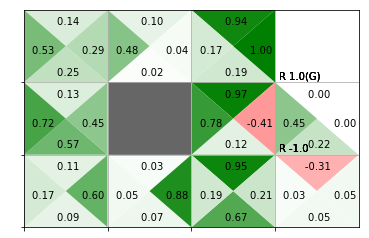

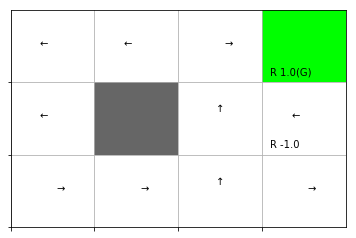

In [6]:
env = GridWorld()
experiences = deque(maxlen=2)
agent = SarsaOffPolicyAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state

env.render_q(agent.Q)

# Q学習

In [7]:
from collections import defaultdict
import numpy as np
from common.gridworld import GridWorld
from common.utils import greedy_action_probs

class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)  # 挙動方策
        self.Q = defaultdict(float)

    def get_action(self, state):
        ps = self.b[state]  # 挙動方策から取得
        actions, probs = list(ps.keys()), list(ps.values())
        return np.random.choice(actions, p=probs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = self.gamma * next_q_max + reward
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        self.pi[state] = greedy_action_probs(self.Q, state, epsilon=0)
        self.b[state] = greedy_action_probs(self.Q, state, self.epsilon)

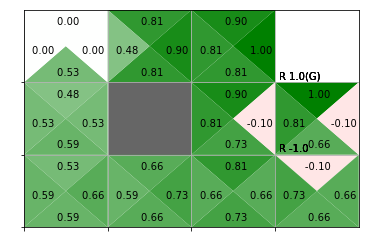

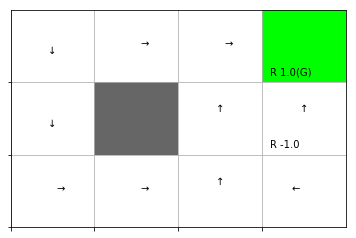

In [8]:
env = GridWorld()
agent = QLearningAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)
        if done:
            break
        state = next_state

env.render_q(agent.Q)